# Imports & settings

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path
import warnings
import copy

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
RAW_DATA_PATH = Path("/home/admin/code/arnaud-odet/7_PhD/Roster/raw_data/muniz_data")
PREPROC_DATA_PATH = Path("/home/admin/code/arnaud-odet/7_PhD/Roster/preproc_data")


sys.path.insert(0, os.path.abspath('..'))
from raw_data.muniz_data.id_dict import pid2name, name2pid

%reload_ext autoreload
%autoreload 2

# Data loading

In [92]:
os.listdir(RAW_DATA_PATH)

['MasterClutch.csv',
 'MasterScore.csv',
 '__pycache__',
 'MasterMisc.csv',
 'Augmented_MasterClutch.csv',
 'id_dict.py',
 'MasterDefense.csv',
 'MasterPass.csv',
 'MasterRebound.csv']

### Duplicated handling

In [93]:
data = {f[6:-4] : pd.read_csv(RAW_DATA_PATH / f, index_col=0).set_index('pidSzn') for f in os.listdir(RAW_DATA_PATH) if 'Clutch' not in f and f[-3:]=='csv'}
for k,v in data.items():
    print(f"{k} - shape = {v.shape} - n° duplicated index = {v.index.duplicated().sum()}")
    # display(v.head(3))

Score - shape = (3131, 34) - n° duplicated index = 91
Misc - shape = (3066, 15) - n° duplicated index = 13
Defense - shape = (3045, 20) - n° duplicated index = 15
Pass - shape = (3092, 48) - n° duplicated index = 39
Rebound - shape = (3053, 25) - n° duplicated index = 0


In [94]:
issues = []
for k,v in data.items():
    for psid in v[v.index.duplicated()].index.unique():
        pid = int(psid.split('_')[0])
        sid = psid.split('_')[-1]
        if psid not in issues :
            issues.append(psid)
            print(f"{k:<12} - {pid2name[pid]:<20} - {sid} ({psid})") 

Score        - Jalen Jones          - 2017-18 (1627883_2017-18)
Score        - Delon Wright         - 2017-18 (1626153_2017-18)
Score        - Alfonzo McKinnie     - 2017-18 (1628035_2017-18)
Score        - Jakob Poeltl         - 2017-18 (1627751_2017-18)
Score        - Charles Cooke        - 2017-18 (1628429_2017-18)
Score        - ETwaun Moore         - 2017-18 (202734_2017-18)
Score        - Fred VanVleet        - 2017-18 (1627832_2017-18)
Score        - Cheick Diallo        - 2017-18 (1627767_2017-18)
Score        - Pascal Siakam        - 2017-18 (1627783_2017-18)
Score        - Darius Miller        - 2017-18 (203121_2017-18)
Score        - CJ Miles             - 2017-18 (101139_2017-18)
Score        - Jameer Nelson        - 2017-18 (2749_2017-18)
Score        - Lucas Nogueira       - 2017-18 (203512_2017-18)
Defense      - Quincy Pondexter     - 2014-15 (202347_2014-15)
Defense      - Corey Brewer         - 2017-18 (201147_2017-18)


In [95]:
for psid in issues :
    print(pid2name[int(psid.split('_')[0])])
    for k,v in data.items():
        if len(v.loc[psid].shape)>1 :
            print(f"    {k}")

Jalen Jones
    Score
    Misc
    Defense
    Pass
Delon Wright
    Score
    Misc
    Defense
    Pass
Alfonzo McKinnie
    Score
    Misc
    Defense
    Pass
Jakob Poeltl
    Score
    Misc
    Defense
    Pass
Charles Cooke
    Score
    Misc
    Defense
    Pass
ETwaun Moore
    Score
    Misc
    Defense
    Pass
Fred VanVleet
    Score
    Misc
    Defense
    Pass
Cheick Diallo
    Score
    Misc
    Defense
    Pass
Pascal Siakam
    Score
    Misc
    Defense
    Pass
Darius Miller
    Score
    Misc
    Defense
    Pass
CJ Miles
    Score
    Misc
    Defense
    Pass
Jameer Nelson
    Score
    Misc
    Defense
    Pass
Lucas Nogueira
    Score
    Misc
    Defense
    Pass
Quincy Pondexter
    Defense
Corey Brewer
    Defense


In [125]:
## Displays duplicated entries in "Score"

# for pl in issues :
#     print(f"{pid2name[int(pl.split('_')[0])]} - {pl.split('_')[-1]}")
#     display(data['Score'].loc[pl])

In [113]:
def handle_duplicates(data):
    rest_data = copy.deepcopy(data)
    for k,v in rest_data.items():
        issues = v[v.index.duplicated()].index.unique()
        v['discard'] = [id in issues for id in v.index] 
        v.reset_index(inplace=True)
        for id in issues:
            keep_index = v[v['pidSzn']==id].sort_values('GP', ascending=False).index[0]
            v.loc[keep_index,'discard'] = False
        v.set_index('pidSzn', inplace= True)
        rest_data[k] = v[v['discard']==False].drop(columns = 'discard')
    return rest_data
        
_test = handle_duplicates(data) 

In [8]:
data['Score']['Season'].unique()

array(['2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20'],
      dtype=object)

In [114]:
data = handle_duplicates(data)

In [115]:
for k,v in data.items():
    print(f"{k} - shape = {v.shape} - n° duplicated index = {v.index.duplicated().sum()}")

Score - shape = (3040, 34) - n° duplicated index = 0
Misc - shape = (3053, 15) - n° duplicated index = 0
Defense - shape = (3030, 20) - n° duplicated index = 0
Pass - shape = (3053, 48) - n° duplicated index = 0
Rebound - shape = (3053, 25) - n° duplicated index = 0


In [156]:
_tmp_list = []
partly_missing = []
for k,v in data.items():
    for kk,vv in data.items():
        n_missing = 0
        for id in v.index :
            if id not in vv.index:
                n_missing += 1
                if not id in partly_missing:
                    partly_missing.append(id)
        _tmp_list.append({'from': k , 'to': kk, 'missing':n_missing})
pd.DataFrame(_tmp_list).pivot(index = 'from', columns = 'to', values = 'missing')

to,Defense,Misc,Pass,Rebound,Score
from,,,,,
Defense,0,0,0,0,8
Misc,23,0,0,0,13
Pass,23,0,0,0,13
Rebound,23,0,0,0,13
Score,18,0,0,0,0


In [158]:
len(partly_missing)

31

### Merging data

In [116]:
# Checks from duplictaed columns appart from MIN, GP and Season
for i,(k,v) in enumerate(data.items()):
    for j, (kk, vv) in enumerate(data.items()): 
        if j > i :
            for col in v.columns :
                if col in vv.columns and col not in ['MIN','GP','Season']:
                    print(f"{col} present in datasets {k} and {kk}")

In [117]:
pl = 'Kevin Durant'
pid = name2pid[pl]
psid = str(pid) + '_2017-18'
for k,v in data.items():
    print(f"{k} - {pl}")
    display(v.loc[psid][['GP','MIN']])

Score - Kevin Durant


GP       68
MIN    34.6
Name: 201142_2017-18, dtype: object

Misc - Kevin Durant


GP       68
MIN    34.6
Name: 201142_2017-18, dtype: object

Defense - Kevin Durant


GP       68
MIN    34.2
Name: 201142_2017-18, dtype: object

Pass - Kevin Durant


GP       68
MIN    34.2
Name: 201142_2017-18, dtype: object

Rebound - Kevin Durant


GP       68
MIN    34.2
Name: 201142_2017-18, dtype: object

In [122]:
# Check if all minutes are relevant between datasets
# Impossible due to duplicate indices
_df = pd.concat([ v[['MIN']].rename(columns = {'MIN':k}) for k,v in data.items() ], axis = 1)

_df['delta'] = _df.max(axis=1) - _df.min(axis = 1)
_df['name'] = [pid2name[int(x.split('_')[0])] for x in _df.index]
_df.sort_values('delta', ascending= False).head(10)

,Score,Misc,Defense,Pass,Rebound,delta,name
pidSzn,,,,,,,
202713_2017-18,5.0,5.0,3.3,4.9,3.3,1.7,Kyle Singler
1628451_2017-18,6.7,6.7,8.1,6.7,8.1,1.4,Jacob Wiley
201587_2019-20,23.3,23.3,22.4,23.0,22.4,0.9,Nicolas Batum
1627733_2019-20,18.1,18.1,18.7,17.8,18.7,0.9,Dragan Bender
2199_2016-17,28.0,28.0,27.3,27.6,27.3,0.7,Tyson Chandler
1627761_2017-18,17.7,17.7,18.2,17.5,18.2,0.7,DeAndre Bembry
2030_2014-15,9.6,9.6,10.2,9.5,10.2,0.7,Kenyon Martin
2555_2017-18,5.1,5.1,4.4,5.0,4.4,0.7,Nick Collison
1629627_2019-20,28.2,28.2,27.5,27.8,27.5,0.7,Zion Williamson


In [134]:
df = pd.concat([v.drop(columns = ['MIN', 'GP', 'Season']) for v in data.values()], axis = 1)
df


,EFG_PCT,TS_PCT,USG_PCT,DD2,TD3,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PTS_PER_ELBOW_TOUCH,...,AVG_DREB_DIST,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_TEAM_REB,PCT_BOX_OUTS_REB
pidSzn,,,,,,,,,,,,,,,,,,,,,
201985_2014-15,0.427,0.451,0.218,0.0,0.0,1.1,0.5,0.2,1.2,0.333,...,11.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201166_2014-15,0.495,0.534,0.246,1.0,0.0,0.8,0.6,1.1,4.3,0.464,...,10.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203932_2014-15,0.478,0.517,0.151,1.0,0.0,1.3,1.0,1.1,3.2,0.643,...,5.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203940_2014-15,0.416,0.443,0.173,3.0,0.0,0.9,1.3,0.2,3.6,0.327,...,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201143_2014-15,0.544,0.563,0.220,14.0,1.0,1.9,1.8,1.3,8.1,0.405,...,5.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204066_2018-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1628424_2018-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1627755_2018-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data quality

In [138]:
n_dupl = df.index.duplicated().sum()
n_any_na = df.isna().any(axis = 1).sum()
print(f"n° duplicated : {n_dupl} | n° line with n.a. : {n_any_na}")

n° duplicated : 0 | n° line with n.a. : 290


In [ ]:
df.isna().sum(axis = 0).sort_values()

OFF_LOOSE_BALLS_RECOVERED      0
SCREEN_AST_PTS                 0
PAINT_TOUCH_PASSES             0
DRIVE_PF_PCT                   0
DRIVE_PF                       0
                            ... 
D_FGM                         23
FREQ                          23
OPP_PTS_FB                    23
FG2_PCT                       36
FG3_PCT                      261
Length: 127, dtype: int64

In [148]:
data['Score'][data['Score']['FG3_PCT'].isna()][['FG3A_FREQUENCY', 'FG3A','FG3_PCT']].sort_values('FG3A')

,FG3A_FREQUENCY,FG3A,FG3_PCT
pidSzn,,,
203945_2014-15,0.0,0.0,NaN
201582_2014-15,0.0,0.0,NaN
1905_2014-15,0.0,0.0,NaN
101106_2014-15,0.0,0.0,NaN
202620_2014-15,0.0,0.0,NaN
...,...,...,...
203497_2019-20,0.0,0.0,NaN
1629605_2019-20,0.0,0.0,NaN
1629076_2019-20,0.0,0.0,NaN


In [149]:
data['Score'][data['Score']['FG2_PCT'].isna()][['FG2A_FREQUENCY', 'FG2A','FG2_PCT']].sort_values('FG2A')

,FG2A_FREQUENCY,FG2A,FG2_PCT
pidSzn,,,
203958_2014-15,0.0,0.0,NaN
203479_2014-15,0.0,0.0,NaN
203925_2015-16,0.0,0.0,NaN
101126_2015-16,0.0,0.0,NaN
1626154_2016-17,0.0,0.0,NaN
1626148_2017-18,0.0,0.0,NaN
1628449_2017-18,0.0,0.0,NaN
204065_2017-18,0.0,0.0,NaN
1628571_2017-18,0.0,0.0,NaN


In [150]:
# Finding : column with most NA is FG3_PCT as some player do not shoot 3s. Filling with 0s
df['FG3_PCT'] = df['FG3_PCT'].fillna(0)
df['FG2_PCT'] = df['FG2_PCT'].fillna(0)


In [151]:
n_dupl = df.index.duplicated().sum()
n_any_na = df.isna().any(axis = 1).sum()
print(f"n° duplicated : {n_dupl} | n° line with n.a. : {n_any_na}")

n° duplicated : 0 | n° line with n.a. : 32


In [163]:
# Analysing players missing in one dataset

data['Score'][data['Score'].index.isin(partly_missing)].sort_values('MIN', ascending=False).head(5)

,EFG_PCT,TS_PCT,USG_PCT,MIN,GP,Season,DD2,TD3,PTS_OFF_TOV,PTS_2ND_CHANCE,...,POST_TOUCH_PTS,POST_TOUCH_FG_PCT,ELBOW_TOUCH_PTS,ELBOW_TOUCH_FG_PCT,FG2A_FREQUENCY,FG2A,FG2_PCT,FG3A_FREQUENCY,FG3A,FG3_PCT
pidSzn,,,,,,,,,,,,,,,,,,,,,
203816_2017-18,0.000,0.266,0.111,8.5,1,2017-18,0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.000,0.0,0.0,NaN
1629147_2018-19,0.333,0.333,0.176,7.9,1,2018-19,0,0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,3.0,0.333,0.0,0.0,NaN
1626176_2015-16,1.000,1.000,0.143,6.2,1,2015-16,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,1.000,0.0,0.0,NaN
2037_2019-20,0.625,0.625,0.235,6.0,1,2019-20,0,0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.5,2.0,0.500,0.5,2.0,0.5
203564_2018-19,0.000,0.532,0.154,5.7,1,2018-19,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,0.0


In [164]:
max_time = 0
for pl in partly_missing:
    for v in data.values():
        if pl in v.index :
            if v.loc[pl,'MIN'] > max_time :
                max_time = v.loc[pl,'MIN']
max_time

np.float64(9.8)

In [173]:
# 32 players are partly missing, none of them playing more than 10 minutes in any dataset, droping them
df = df.dropna()
df

,EFG_PCT,TS_PCT,USG_PCT,DD2,TD3,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PTS_PER_ELBOW_TOUCH,...,AVG_DREB_DIST,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_TEAM_REB,PCT_BOX_OUTS_REB
pidSzn,,,,,,,,,,,,,,,,,,,,,
201985_2014-15,0.427,0.451,0.218,0.0,0.0,1.1,0.5,0.2,1.2,0.333,...,11.7,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000
201166_2014-15,0.495,0.534,0.246,1.0,0.0,0.8,0.6,1.1,4.3,0.464,...,10.3,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000
203932_2014-15,0.478,0.517,0.151,1.0,0.0,1.3,1.0,1.1,3.2,0.643,...,5.8,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000
203940_2014-15,0.416,0.443,0.173,3.0,0.0,0.9,1.3,0.2,3.6,0.327,...,4.5,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000
201143_2014-15,0.544,0.563,0.220,14.0,1.0,1.9,1.8,1.3,8.1,0.405,...,5.7,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203897_2019-20,0.526,0.568,0.312,2.0,0.0,4.6,2.2,3.6,10.2,1.070,...,6.8,0.07,0.80,0.87,0.50,0.15,0.077,0.923,0.882,0.265
1629668_2019-20,0.375,0.402,0.147,0.0,0.0,0.0,0.0,0.6,0.0,0.000,...,12.8,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000
1629015_2019-20,0.273,0.313,0.165,0.0,0.0,0.1,0.3,0.0,0.9,0.000,...,16.3,0.00,0.14,0.14,0.00,0.00,0.000,1.000,0.000,0.000


# Clustering

### VIF

In [174]:
# Steps worth enriching later on : 
#   duplicated entries (entries with most game played was kept, but it was also duplicated)
#   droping player missing is any of the dataset    

df

,EFG_PCT,TS_PCT,USG_PCT,DD2,TD3,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PTS_PER_ELBOW_TOUCH,...,AVG_DREB_DIST,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_TEAM_REB,PCT_BOX_OUTS_REB
pidSzn,,,,,,,,,,,,,,,,,,,,,
201985_2014-15,0.427,0.451,0.218,0.0,0.0,1.1,0.5,0.2,1.2,0.333,...,11.7,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000
201166_2014-15,0.495,0.534,0.246,1.0,0.0,0.8,0.6,1.1,4.3,0.464,...,10.3,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000
203932_2014-15,0.478,0.517,0.151,1.0,0.0,1.3,1.0,1.1,3.2,0.643,...,5.8,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000
203940_2014-15,0.416,0.443,0.173,3.0,0.0,0.9,1.3,0.2,3.6,0.327,...,4.5,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000
201143_2014-15,0.544,0.563,0.220,14.0,1.0,1.9,1.8,1.3,8.1,0.405,...,5.7,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203897_2019-20,0.526,0.568,0.312,2.0,0.0,4.6,2.2,3.6,10.2,1.070,...,6.8,0.07,0.80,0.87,0.50,0.15,0.077,0.923,0.882,0.265
1629668_2019-20,0.375,0.402,0.147,0.0,0.0,0.0,0.0,0.6,0.0,0.000,...,12.8,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000
1629015_2019-20,0.273,0.313,0.165,0.0,0.0,0.1,0.3,0.0,0.9,0.000,...,16.3,0.00,0.14,0.14,0.00,0.00,0.000,1.000,0.000,0.000


In [201]:
drop_cols = ['FREQ','BOX_OUTS','DIST_MILES','AVG_SPEED']

In [202]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

for col in drop_cols:
    if col in df.columns:
        df = df.drop(columns = col)

all_vif = pd.DataFrame()
all_vif["features"] = df.columns
all_vif["vif_index"] = [vif(df.values, i) for i in range(df.shape[1])]
round(all_vif.sort_values(by="vif_index", ascending=False), 2)[:10]

,features,vif_index
93,TOUCHES,15590.28
85,PASSES_MADE,7692.14
48,D_FG_PCT,1747.87
25,FG2A_FREQUENCY,1492.91
57,SCREEN_ASSISTS,730.77
58,SCREEN_AST_PTS,722.43
40,AVG_SPEED_DEF,674.02
37,DIST_MILES_OFF,650.39
38,DIST_MILES_DEF,650.31
47,D_FGA,609.42


### PCA

In [203]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled

array([[-0.69637385, -0.80772309,  0.70957423, ..., -0.99056257,
        -0.9635799 , -0.73918298],
       [-0.0140954 ,  0.05472346,  1.25139667, ..., -0.99056257,
        -0.9635799 , -0.73918298],
       [-0.18466501, -0.12192222, -0.58692948, ..., -0.99056257,
        -0.9635799 , -0.73918298],
       ...,
       [-2.24153387, -2.24167036, -0.31601825, ...,  1.18978309,
        -0.9635799 , -0.73918298],
       [ 0.95915474,  0.90677909,  2.12218274, ...,  1.03497855,
         0.70389602,  3.09414763],
       [ 1.71166774,  1.43671612, -1.51576795, ..., -0.26450747,
        -0.9635799 , -0.73918298]], shape=(3021, 123))

In [204]:
from sklearn.decomposition import PCA


pca = PCA()
pca.fit(df_scaled)
W = pca.components_

W = pd.DataFrame(W.T,
                index=df.columns,
                columns=[f'PC{i}' for i in range(1, len(df.columns)+1)])
display(W)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123
EFG_PCT,0.059873,-0.031673,0.070570,0.138794,-0.158163,0.224402,0.256098,0.029942,0.126006,-0.064402,...,0.036539,-0.008125,-0.010376,-0.017327,-0.016272,0.009508,-0.009975,-0.000390,0.004974,-5.536452e-06
TS_PCT,0.067845,-0.021667,0.062510,0.138115,-0.130390,0.223799,0.265389,0.045087,0.134812,-0.058094,...,-0.010048,0.009207,0.006411,0.003364,0.005377,-0.002410,0.010071,-0.000237,-0.003597,2.826052e-06
USG_PCT,0.092187,0.067778,-0.065815,0.037418,0.278607,-0.027299,0.132424,0.023080,0.080774,-0.024860,...,-0.009430,0.013615,-0.002385,-0.002670,0.005033,-0.004502,0.000690,0.001517,-0.001966,4.294065e-07
DD2,0.127409,-0.039135,-0.050724,-0.075021,0.061482,-0.047485,0.015678,-0.026151,0.012424,-0.056518,...,0.007899,-0.001837,0.001861,0.002210,-0.001065,0.000160,0.003973,-0.003403,0.000067,8.171025e-06
TD3,0.049747,0.038088,-0.025478,-0.077954,0.087649,0.021513,0.033299,-0.056449,0.001919,0.135082,...,0.003626,-0.002641,0.002321,-0.000217,0.001068,0.000697,0.000161,-0.000054,-0.000761,4.790625e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BOX_OUT_PLAYER_REBS,0.078742,-0.094168,0.193921,-0.116042,0.028599,-0.039039,0.046661,0.003663,0.219952,-0.070451,...,0.059127,-0.041895,0.006037,0.045476,-0.022412,-0.007326,0.000550,0.001887,-0.001810,-1.109710e-05
PCT_BOX_OUTS_OFF,0.036523,-0.061941,0.187658,-0.097165,0.065916,0.050691,0.034382,-0.005028,0.105489,0.011484,...,-0.002619,0.003868,0.000982,0.000727,-0.001721,-0.002902,0.004831,0.000519,0.000444,-1.039178e-05
PCT_BOX_OUTS_DEF,0.016897,0.014998,0.290377,-0.058597,0.074380,-0.027585,0.059713,-0.012695,-0.144110,0.064671,...,-0.032882,0.030973,-0.014026,-0.018062,-0.007945,-0.020027,0.006964,-0.001285,0.000969,-1.696436e-05
PCT_BOX_OUTS_TEAM_REB,0.028248,0.003272,0.297813,-0.067717,0.070185,-0.012058,0.065964,-0.000710,-0.098083,0.064089,...,0.046676,-0.039965,0.027932,0.023116,0.008077,0.016178,-0.005329,0.000150,-0.002386,2.474019e-06


In [213]:
pca.explained_variance_ratio_[:5].round(2)

array([0.26, 0.17, 0.06, 0.04, 0.03])

In [206]:
def find_n_PC(pca_evr,threshold, display_fig = True):
    cs = np.cumsum(pca_evr)
    above = cs >= threshold
    n = above.argmax() +1
    print(f"Threshold {threshold:.2f} reached with {n} Principal Components")
    if display_fig:
        fig, axs = plt.subplots(1,1,figsize = (16,5))
        plt.plot(cs);
        plt.plot([0,n-1],[cs[n-1],cs[n-1]], ls = '-', c = 'red');
        plt.plot([n-1,n-1],[cs[0],cs[n-1]], ls = '-', c = 'red');
        plt.xticks(ticks= range(len(cs)),labels=[i+1 for i in range(len(cs))])
    
    return n

Threshold 0.70 reached with 13 Principal Components


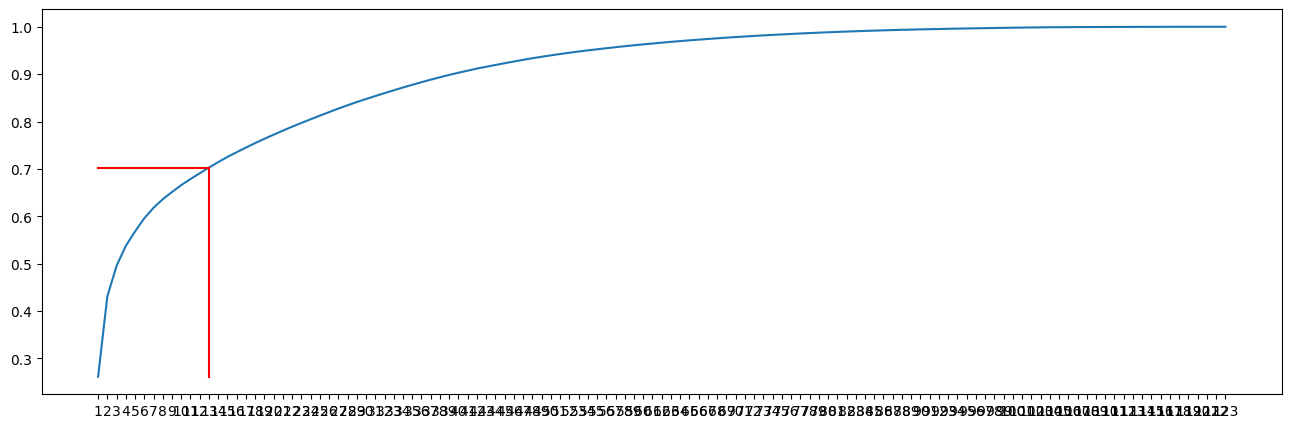

In [209]:
n_PCA = find_n_PC(pca.explained_variance_ratio_, 0.7)

In [210]:
final_PCA = PCA(n_components=n_PCA)
final_PCA.fit(df_scaled)
X_proj = final_PCA.transform(df_scaled)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i+1}' for i in range(n_PCA)], index = df.index)

X_proj

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
pidSzn,,,,,,,,,,,,,
201985_2014-15,-4.400090,3.498701,-2.318003,-0.960185,0.470051,0.754471,2.065675,0.860205,3.141625,0.747675,0.911229,4.400194,1.755449
201166_2014-15,-0.331742,6.802626,-3.017107,-0.851067,0.572837,0.560872,0.174245,0.088163,2.597222,-0.958592,0.940378,-0.982847,0.901993
203932_2014-15,-3.264866,-1.965608,-1.717441,2.111037,0.735731,2.100419,-0.880523,-1.158143,-0.378422,0.252055,1.383149,0.202107,-0.527428
203940_2014-15,1.755671,-4.180957,-4.281586,-0.099434,-0.687923,-0.581263,-2.311482,2.560958,-0.668795,0.219962,-0.036264,0.475489,1.674584
201143_2014-15,8.559013,-4.309638,-6.319661,-0.195847,-2.701600,-1.148849,1.953332,-0.510948,-2.447748,-0.579369,-0.826398,0.972948,0.689409
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203897_2019-20,8.796774,8.044657,1.710723,3.020088,4.162084,1.880770,-1.107206,-0.709029,-0.055924,-0.036761,0.535557,-0.751862,0.895287
1629668_2019-20,-8.035936,1.713881,0.456190,-1.330190,1.599368,-5.129959,-2.503686,3.736540,-0.322618,-1.562593,0.212787,-1.929163,-1.909098
1629015_2019-20,-9.110232,-0.053474,-0.480848,-1.989086,4.073802,-1.870514,-1.023246,3.490088,-1.514556,-1.602817,0.250590,-0.617197,-3.027201


### k-Means & HAC

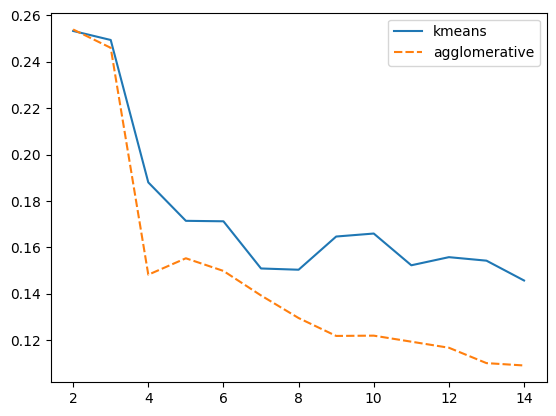

In [211]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

clustering_methods = {
    'kmeans' : KMeans,
    'agglomerative': AgglomerativeClustering    
}
clustering_silhouettes = pd.DataFrame(index = range(2,15), columns = clustering_methods.keys())

for k in range(2,15):
    for name, object in clustering_methods.items():
        clustering = object(n_clusters= k).fit(X_proj) if name == 'kmeans' else object(n_clusters= k, linkage= 'ward').fit(X_proj)
        labels = clustering.labels_
        clustering_silhouettes.loc[k,name] = silhouette_score(X_proj, labels) 

sns.lineplot(data=clustering_silhouettes);